# Проект "Мобильные телесистемы".

<b>Цель:</b> Нужно проанализировать поведение абонентов двух тарифов мобильной связи и сделать вывод — какой тариф лучше.

<b>Задачи:</b> 
* Рассчитать количество звонков, смс-сообщений и мегабайт интернет-траффика абонентов.
* Рассчитать доход от использования тарифов.
* Сформулировать и проверить гипотезы по сравнению тарифов.


<b>Описание тарифов</b>

<b>Тариф «Смарт»</b>
1.	Ежемесячная плата: 550 рублей
2.	Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
*	минута разговора: 3 рубля
*	сообщение: 3 рубля
*	1 Гб интернет-трафика: 200 рублей

<b>Тариф «Ультра»</b>
1.	Ежемесячная плата: 1950 рублей
2.	Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
*	минута разговора: 1 рубль
*	сообщение: 1 рубль
*	1 Гб интернет-трафика: 150 рублей

<b>Примечание:</b>

Оператор мобильной связи всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.


<b>Описание данных</b>

Таблица users (информация о пользователях):
*	user_id — уникальный идентификатор пользователя
*	first_name — имя пользователя
*	last_name — фамилия пользователя
*	age — возраст пользователя (годы)
*	reg_date — дата подключения тарифа (день, месяц, год)
*	churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
*	city — город проживания пользователя
*	tariff — название тарифного плана

Таблица calls (информация о звонках):
*	id — уникальный номер звонка
*	call_date — дата звонка
*	duration — длительность звонка в минутах
*	user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):
*	id — уникальный номер сообщения
*	message_date — дата сообщения
*	user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):
*	id — уникальный номер сессии
*	mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
*	session_date — дата интернет-сессии
*	user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):
*	tariff_name — название тарифа
*	rub_monthly_fee — ежемесячная абонентская плата в рублях
*	minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
*	messages_included — количество сообщений в месяц, включённых в абонентскую плату
*	mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
*	rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
*	rub_per_message — стоимость отправки сообщения сверх тарифного пакета
*	rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## 1. Обзор данных

Импортируем библиотеки pandas, numpy, matplotlib и scipy.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st

Загрузим данные из csv-файлов.

In [2]:
users = pd.read_csv('/datasets/users.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')

Сделаем обзор датафрейма <b>users.</b>

In [3]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Колонки 'churn_date' и 'reg_date' строкового типа содержат дату. Для работы с датой нужно изменить тип на datetime.

Пропуски в 'churn_date' означают, что тариф действующий.

Рассмотрим датафрейм <b>tariffs.</b>

In [5]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [6]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Для анализа данных нужно будет объединять датафреймы users и tariffs, поэтому колонку 'tafiff_name' в датафрейме 'tariff' лучше переименовать в 'tariff' (как в датафрейме users)

Сделаем обзор датафрема <b>calls</b>.

In [7]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [8]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Колонка 'call_date' строкового типа содержит дату. Для работы с датой нужно изменить тип на datetime.

In [9]:
calls.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,202607.0,6.755887,5.843365,0.0,1.3,6.0,10.7,38.0
user_id,202607.0,1253.940619,144.722751,1000.0,1126.0,1260.0,1379.0,1499.0


В колонке duration есть значения 0. Скорее всего, это пропущенные вызовы.

Теперь рассмотрим датафрейм <b>internet</b>

In [10]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


В датафрейме internet есть безымянная колонка (она отсутствует в описании данных), данные в которой, скорее всего, дублируют индекс.  Проверим это, выбрав 10 случайных строк.

In [11]:
internet.sample(10)

,Unnamed: 0,id,mb_used,session_date,user_id
27389,27389,1094_251,466.86,2018-12-29,1094
37509,37509,1130_407,373.58,2018-08-17,1130
93042,93042,1314_396,797.46,2018-06-08,1314
26065,26065,1090_1,716.06,2018-11-09,1090
143439,143439,1480_127,0.00,2018-05-19,1480
121544,121544,1410_18,324.09,2018-09-04,1410
30759,30759,1107_242,705.63,2018-11-04,1107
51524,51524,1175_177,265.29,2018-08-24,1175
59128,59128,1199_87,0.00,2018-11-10,1199
38368,38368,1134_423,318.54,2018-12-10,1134


Действительно, колонка просто дублирует индекс, и ее можно удалить.

In [12]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [13]:
internet.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,149396.0,74697.500000,43127.054745,0.0,37348.7500,74697.500,112046.2500,149395.00
mb_used,149396.0,370.192426,278.300951,0.0,138.1875,348.015,559.5525,1724.83
user_id,149396.0,1252.099842,144.050823,1000.0,1130.0000,1251.000,1380.0000,1499.00


Колонка 'session_date' строкового типа содержит дату. Для работы с датой нужно изменить тип на datetime.

Сделаем обзор датафрейма <b>messages.</b>.

In [14]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [15]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Колонка 'message_date' строкового типа содержит дату. Для работы с датой нужно изменить тип на datetime.

### Вывод

Пропуски только в датафрейме users в колонке 'churn_date', т.к. это дата смены тарифа, и если она не заполнена, то тариф действующий.
В остальных датафреймах пропусков нет.


* Нужно сделать преобразование типов данных из object в datetime:
    * users - 'churn_date' и 'reg_date';
    * calls - 'call_date';
    * internet - 'session_date';
    * messages - 'message_date'.
    

* Нужно добавить в таблицы calls, internet и messages колонку 'month' для анализа данных по месяцам.

* Нужно привести к целочисленному типу и округлить в большую сторону колонку 'duration' в calls, так как каждый звонок компанией «Мегалайн» округляется отдельно.

* Колонку 'tafiff_name' в датафрейме 'tariff' нужно переименовать в 'tariff' (как в датафрейме users).


## 2 Предобработка данных

### 2.1. Проверка на наличие дубликатов

In [16]:
dfs = [users, tariffs, calls, internet, messages]
df_names = ['users', 'tariffs', 'calls', 'internet', 'messages']
for df, df_name in zip(dfs, df_names):
    print(df_name, ':', df.duplicated().sum())

users : 0
tariffs : 0
calls : 0
internet : 0
messages : 0


Ни в одном из датафреймов нет дубликатов.

### 2.2. Изменение типов данных и названий колонок.

Так как для каждого звонка длительность разговора округляется до минут, округлим колонку 'duration' в большую сторону, и  изменим ее тип на int.

In [17]:
calls['duration'] = np.ceil(calls['duration']).astype('int')

In [18]:
calls.sample()

,id,call_date,duration,user_id
176827,1436_272,2018-04-21,22,1436


In [19]:
internet.sample()

,Unnamed: 0,id,mb_used,session_date,user_id
57602,57602,1193_141,140.73,2018-08-08,1193


Удалим лишнюю колонку в датафрейме internet.

In [20]:
internet.columns

Index(['Unnamed: 0', 'id', 'mb_used', 'session_date', 'user_id'], dtype='object')

In [21]:
internet.drop(['Unnamed: 0'],axis=1,inplace = True)

In [22]:
internet.sample()

,id,mb_used,session_date,user_id
90479,1307_96,516.75,2018-10-20,1307


Преобразуем в датафрейме users тип данных в колонке 'reg_date' в datetime. Если есть ошибочно заполненные даты, сохраним индексы строк таких данных в список bad_date_indexes.

In [23]:
dfs = [users,users,calls,internet,messages]
df_names = ['users', 'users', 'calls', 'internet', 'messages']
columns = ['reg_date', 'churn_date', 'call_date', 'session_date', 'message_date']
for df, column, df_name in zip(dfs, columns, df_names):
    bad_date_indexes = []
    try:
        df[column] = pd.to_datetime(df[column], format = '%Y-%m-%d')
    except:
        bad_date_indexes.append(df.index)
    print(f'{df_name}["{column}"]: bad_date_indexes = {bad_date_indexes}')

users["reg_date"]: bad_date_indexes = []
users["churn_date"]: bad_date_indexes = []
calls["call_date"]: bad_date_indexes = []
internet["session_date"]: bad_date_indexes = []
messages["message_date"]: bad_date_indexes = []


Преобразование дат прошло успешно (все списки bad_date_indexes пусты).

In [24]:
for df,df_name in zip(dfs, df_names):
    print(df_name, ':')
    df.info()
    print()

users :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB

users :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     

Переименуем колонку 'tariff_name' в 'tariff' в датафрейме tariff.

In [25]:
tariffs = tariffs.rename(columns = {'tariff_name': 'tariff'})

### 2.3. Добавление новых колонок в датафреймы

Нужно добавить в таблицы calls, internet и messages колонку 'month' для анализа данных по месяцам.

In [26]:
calls['month'] = calls['call_date'].astype('datetime64[M]')
calls.sample()

,id,call_date,duration,user_id,month
110689,1284_287,2018-06-21,5,1284,2018-06-01


In [27]:
internet['month'] = internet['session_date'].astype('datetime64[M]')
internet.sample()

,id,mb_used,session_date,user_id,month
9212,1032_292,360.52,2018-11-20,1032,2018-11-01


In [28]:
messages['month'] = messages['message_date'].astype('datetime64[M]')
messages.sample()

,id,message_date,user_id,month
82584,1344_648,2018-10-23,1344,2018-10-01


## 3. Подготовка данных для исследования

Для исследования для каждого пользователя нужно посчитать:

*	количество сделанных звонков и израсходованных минут разговора по месяцам;
*	количество отправленных сообщений по месяцам;
*	объем израсходованного интернет-трафика по месяцам;
*	помесячную выручку с каждого пользователя (вычесть бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножить на значение из тарифного плана; прибавить абонентскую плату, соответствующую тарифному плану).


#### 3.1. Подготовка данных по звонкам

Для исследования данных по звонкам (количество звонков, число использованных минут разговора) нужны будут данные из датафрейма calls. 

Но нужно решить, как включать в исследование данные о звонках, которые были сделаны в месяц подключения к тарифу и в месяц отказа от тарифа. Если пользователь подключился к тарифу в конце месяца (или отказался от тарифа в начале месяца), то в этом случае данные о звонках могут повлиять на среднее значение.

Дата регистрации и дата отказа от тарифа находятся в датафрейме users, поэтому объединим users и calls методом merge().

Так как данные нового датафрейма будем группировать по месяцам, новый датафрейм назовем calls_per_month.

In [29]:
calls_per_month = calls.merge(users[['user_id','reg_date','churn_date']], on = 'user_id', how='left')
calls_per_month['user_id'].count()
calls_per_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202607 entries, 0 to 202606
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id          202607 non-null  object        
 1   call_date   202607 non-null  datetime64[ns]
 2   duration    202607 non-null  int32         
 3   user_id     202607 non-null  int64         
 4   month       202607 non-null  datetime64[ns]
 5   reg_date    202607 non-null  datetime64[ns]
 6   churn_date  9919 non-null    datetime64[ns]
dtypes: datetime64[ns](4), int32(1), int64(1), object(1)
memory usage: 11.6+ MB


В датафрейме 202615 записей.

Выберем записи о звонках, которые приходятся на месяц регистрации или отказа от тарифа.

In [30]:
calls_per_month[(calls_per_month['reg_date'].dt.month == calls_per_month['call_date'].dt.month) |
           (calls_per_month['churn_date'].dt.month == calls_per_month['call_date'].dt.month)]['user_id'].count()

19092

In [31]:
round(19092 / 202615 * 100,2)

9.42

Таких записей 9.42%. 

Чтобы не удалять все данные за месяц регистрации/отказа от тарифа, можно взять данные о звонках, если регистрация прошла не позднее 5 числа месяца или отказ от тарифа прошел не раньше 25 числа месяца. Проверим, сколько данных НЕ войдут в исследование при таких условиях.

In [32]:
calls_per_month[((calls_per_month['reg_date'].dt.month == calls_per_month['call_date'].dt.month) &
             (calls_per_month['reg_date'].dt.day > 5)) |
            ((calls_per_month['churn_date'].dt.month == calls_per_month['call_date'].dt.month) &
             (calls_per_month['churn_date'].dt.day < 25))]['user_id'].count()

12970

In [33]:
round(12970 / 202607 * 100,2)

6.4

Таких записей меньше - 6.4%. Применим это правило (если месяц звонка совпадает с месяцем регистрации отказа от тарифа, и регистрация прошла не позднее 5 числа месяца или отказ от тарифа прошел не раньше 25 числа месяца, тогда включаем данные звонак в датафрейм).

По такому же принципу будем отбирать данные по смс-сообщениям и траффику интернета.

In [34]:
calls_per_month = calls_per_month[((calls_per_month['reg_date'].dt.month != calls_per_month['call_date'].dt.month) |
             (calls_per_month['reg_date'].dt.day <= 5)) &
            ((calls_per_month['churn_date'].dt.month != calls_per_month['call_date'].dt.month) |
             (calls_per_month['churn_date'].dt.day >=25))]
calls_per_month.head()

,id,call_date,duration,user_id,month,reg_date,churn_date
0,1000_0,2018-07-25,0,1000,2018-07-01,2018-05-25,NaT
1,1000_1,2018-08-17,0,1000,2018-08-01,2018-05-25,NaT
2,1000_2,2018-06-11,3,1000,2018-06-01,2018-05-25,NaT
3,1000_3,2018-09-21,14,1000,2018-09-01,2018-05-25,NaT
4,1000_4,2018-12-15,6,1000,2018-12-01,2018-05-25,NaT


Вычислим количество звонков и суммарное количество минут за каждый месяц для каждого пользователя. reset_index() нужен, чтобы user_id и month были колонками, а не мультииндексом.

In [35]:
calls_per_month = calls_per_month.groupby(['user_id','month'])['duration'].agg(['count','sum']).reset_index()
calls_per_month.head()

,user_id,month,count,sum
0,1000,2018-06-01,43,172
1,1000,2018-07-01,47,340
2,1000,2018-08-01,52,408
3,1000,2018-09-01,58,466
4,1000,2018-10-01,57,350


Переименуем колонки 'coun't в 'calls', а 'sum' в 'minutes'.

In [36]:
calls_per_month.columns = ['user_id','month','calls','minutes']
calls_per_month.head()

,user_id,month,calls,minutes
0,1000,2018-06-01,43,172
1,1000,2018-07-01,47,340
2,1000,2018-08-01,52,408
3,1000,2018-09-01,58,466
4,1000,2018-10-01,57,350


Теперь вычислим помесячную выручку от телефонных разговоров сверх лимита с каждого пользователя.

Для вычисления выручки по минутам из датафрейма tariffs возьмем информацию о минутах тарифа.

In [37]:
calls_per_month = calls_per_month.merge(users[['user_id','tariff']],on = 'user_id',how='left')\
                                 .merge(tariffs[['tariff','minutes_included','rub_per_minute']], on = 'tariff')
calls_per_month.head()

,user_id,month,calls,minutes,tariff,minutes_included,rub_per_minute
0,1000,2018-06-01,43,172,ultra,3000,1
1,1000,2018-07-01,47,340,ultra,3000,1
2,1000,2018-08-01,52,408,ultra,3000,1
3,1000,2018-09-01,58,466,ultra,3000,1
4,1000,2018-10-01,57,350,ultra,3000,1


В колонку 'minutes_income' поместим выручку от использования минут разговора сверх лимита.

In [38]:
# Из количества минут разговора вычтем количество минут, включенных в тариф, и умножим на стоимость минут вне лимита
calls_per_month['minutes_income'] = (calls_per_month['minutes'] - calls_per_month['minutes_included']) * \
                                     calls_per_month['rub_per_minute']
# Если лимит неизрасходован, то значение в колонке 'minutes_income' будет  <0, т.е. прибыль будет =0
calls_per_month.loc[calls_per_month['minutes_income'] < 0,'minutes_income'] = 0
calls_per_month.head()

,user_id,month,calls,minutes,tariff,minutes_included,rub_per_minute,minutes_income
0,1000,2018-06-01,43,172,ultra,3000,1,0
1,1000,2018-07-01,47,340,ultra,3000,1,0
2,1000,2018-08-01,52,408,ultra,3000,1,0
3,1000,2018-09-01,58,466,ultra,3000,1,0
4,1000,2018-10-01,57,350,ultra,3000,1,0


#### 3.2. Подготовка данных по смс-сообщениям

Для исследования данных по сообщениям  нужны будут данные из датафрейма messages. 

Дата регистрации и дата отказа от тарифа находятся в датафрейме users, поэтому объединим users и messages методом merge().

Так как данные нового датафрейма будем группировать по месяцам, назовем его messages_per_month.

In [39]:
messages_per_month = messages.merge(users[['user_id','reg_date','churn_date']], on = 'user_id', how='left')
messages_per_month['user_id'].count()

123036

Если регистрация была позднее 5 числа месяца или отказ от тарифа позднее 25 числа месяца, то данные о месяце регистрации/отказа не включаем.

In [40]:
messages_per_month = messages_per_month[((messages_per_month['reg_date'].dt.month != \
                                          messages_per_month['message_date'].dt.month) |
                                         (messages_per_month['reg_date'].dt.day <= 5)) &
                                        ((messages_per_month['churn_date'].dt.month != \
                                          messages_per_month['message_date'].dt.month) |
                                         (messages_per_month['churn_date'].dt.day >=25))]
messages_per_month.head(5)

,id,message_date,user_id,month,reg_date,churn_date
0,1000_0,2018-06-27,1000,2018-06-01,2018-05-25,NaT
1,1000_1,2018-10-08,1000,2018-10-01,2018-05-25,NaT
2,1000_2,2018-08-04,1000,2018-08-01,2018-05-25,NaT
3,1000_3,2018-06-16,1000,2018-06-01,2018-05-25,NaT
4,1000_4,2018-12-05,1000,2018-12-01,2018-05-25,NaT


Вычислим, количество сообщений за каждый месяц для каждого пользователя.

In [41]:
messages_per_month = messages_per_month.groupby(['user_id','month'])['id'].agg('count').reset_index()
display(messages_per_month.head())

,user_id,month,id
0,1000,2018-06-01,60
1,1000,2018-07-01,75
2,1000,2018-08-01,81
3,1000,2018-09-01,57
4,1000,2018-10-01,73


В колонке 'id' находится количество смс-сообщений, поэтому переименуем ее в 'messages'.

In [42]:
messages_per_month.columns = ['user_id','month','messages']

Для дальнейшего анализа из датафрейма tariffs возьмем информацию о сообщениях для соответствующего тарифа.

In [43]:
messages_per_month = messages_per_month.merge(users[['user_id','tariff']],on = 'user_id',how='left')\
                                       .merge(tariffs[['tariff','messages_included','rub_per_message']], on = 'tariff')
messages_per_month.head()

,user_id,month,messages,tariff,messages_included,rub_per_message
0,1000,2018-06-01,60,ultra,1000,1
1,1000,2018-07-01,75,ultra,1000,1
2,1000,2018-08-01,81,ultra,1000,1
3,1000,2018-09-01,57,ultra,1000,1
4,1000,2018-10-01,73,ultra,1000,1


В колонку 'messages_income' поместим выручку от использования минут разговора сверх лимита.

In [44]:
# Из количества сообщений пользователя вычтем количество сообщений, включенных в тариф, и умножим на стоимость сообщения вне лимита
messages_per_month['messages_income'] = (messages_per_month['messages'] - messages_per_month['messages_included']) * \
                                         messages_per_month['rub_per_message']
# Если лимит неизрасходован, то значение в колонке 'messages_income' будет <0, и прибыль будет =0
messages_per_month.loc[messages_per_month['messages_income'] < 0,'messages_income'] = 0
messages_per_month.head()

,user_id,month,messages,tariff,messages_included,rub_per_message,messages_income
0,1000,2018-06-01,60,ultra,1000,1,0
1,1000,2018-07-01,75,ultra,1000,1,0
2,1000,2018-08-01,81,ultra,1000,1,0
3,1000,2018-09-01,57,ultra,1000,1,0
4,1000,2018-10-01,73,ultra,1000,1,0


#### 3.3. Подготовка данных по интернет-сессиям 

Для исследования данных об интернет-сессиях нужны будут данные из датафрейма internet. 

Дата регистрации и дата отказа от тарифа находятся в датафрейме users, поэтому объединим internet и users методом merge().

Так как данные нового датафрейма будем группировать по месяцам, новый датафрейм назовем internet_per_month.

In [45]:
internet_per_month = internet.merge(users[['user_id','reg_date','churn_date']], on = 'user_id', how='left')
internet_per_month['user_id'].count()

149396

Если регистрация была позднее 5 числа месяца или откказ от тарифа позднее 25 числа месяца, то данные о месяце регистрации/отказа не включаем.

In [46]:
internet_per_month = internet_per_month[((internet_per_month['reg_date'].dt.month != \
                                          internet_per_month['session_date'].dt.month) | \
                                         (internet_per_month['reg_date'].dt.day <= 5)) & \
                                        ((internet_per_month['churn_date'].dt.month != \
                                          internet_per_month['session_date'].dt.month) | \
                                         (internet_per_month['churn_date'].dt.day >=25))]
internet_per_month.head()

,id,mb_used,session_date,user_id,month,reg_date,churn_date
0,1000_0,112.95,2018-11-25,1000,2018-11-01,2018-05-25,NaT
1,1000_1,1052.81,2018-09-07,1000,2018-09-01,2018-05-25,NaT
2,1000_2,1197.26,2018-06-25,1000,2018-06-01,2018-05-25,NaT
3,1000_3,550.27,2018-08-22,1000,2018-08-01,2018-05-25,NaT
4,1000_4,302.56,2018-09-24,1000,2018-09-01,2018-05-25,NaT


Вычислим количество использованных мегабайт за каждый месяц для каждого пользователя, округлим его в большую сторону, т.к. оператор округляет в большую сторону объем интернет-траффика за весь месяц.

In [47]:
internet_per_month = np.ceil(internet_per_month.groupby(['user_id','month'])['mb_used'].agg('sum')).reset_index()
display(internet_per_month.head())

,user_id,month,mb_used
0,1000,2018-06-01,23234.0
1,1000,2018-07-01,14004.0
2,1000,2018-08-01,14056.0
3,1000,2018-09-01,14569.0
4,1000,2018-10-01,14703.0


Для дальнейшего анализа из датафрейма tariffs возьмем информацию, касающуюся интернета соответствующего тарифа.

In [48]:
internet_per_month = internet_per_month.merge(users[['user_id','tariff']],on = 'user_id',how='left')\
                                       .merge(tariffs[['tariff','mb_per_month_included','rub_per_gb']], on = 'tariff')
internet_per_month.head()

,user_id,month,mb_used,tariff,mb_per_month_included,rub_per_gb
0,1000,2018-06-01,23234.0,ultra,30720,150
1,1000,2018-07-01,14004.0,ultra,30720,150
2,1000,2018-08-01,14056.0,ultra,30720,150
3,1000,2018-09-01,14569.0,ultra,30720,150
4,1000,2018-10-01,14703.0,ultra,30720,150


В колонку 'internet_income' поместим выручку от использования интернет-траффика сверх лимита (Мб переведем в Гб, округлив результат в большую сторону).

In [49]:
# Из количества израсходованных Мб интернета вычтем количество Мб, включенных в тариф,переведем в Гб и умножим на стоимость Гб интернета вне лимита
internet_per_month['internet_income'] = np.ceil((internet_per_month['mb_used'] - \
                                                 internet_per_month['mb_per_month_included'])/1024) * \
                                                 internet_per_month['rub_per_gb']
# Если лимит неизрасходован, то значение в колонке будет 'messages_income'<0, и прибыль будет =0
internet_per_month.loc[internet_per_month['internet_income'] < 0,'internet_income'] = 0
internet_per_month.head()

,user_id,month,mb_used,tariff,mb_per_month_included,rub_per_gb,internet_income
0,1000,2018-06-01,23234.0,ultra,30720,150,0.0
1,1000,2018-07-01,14004.0,ultra,30720,150,0.0
2,1000,2018-08-01,14056.0,ultra,30720,150,0.0
3,1000,2018-09-01,14569.0,ultra,30720,150,0.0
4,1000,2018-10-01,14703.0,ultra,30720,150,0.0


#### 3.4. Объединение данных по звонкам, сообщениям и интернет-сессиям

Объединим данные по звонкам, сообщениям и интернет-сессиям в датафрейм used_per_month.

In [50]:
used_per_month = calls_per_month[['user_id','month','calls','minutes','minutes_income']]\
                                .merge(messages_per_month[['user_id','month','messages','messages_income']],\
                                       on=['user_id','month'],how='outer')\
                                .merge(internet_per_month[['user_id','month','mb_used','internet_income']], \
                                       on = ['user_id','month'],how='outer')\
                                .merge(users[['user_id','tariff','city']],on = ['user_id'])
used_per_month.head()

,user_id,month,calls,minutes,minutes_income,messages,messages_income,mb_used,internet_income,tariff,city
0,1000,2018-06-01,43.0,172.0,0.0,60.0,0.0,23234.0,0.0,ultra,Краснодар
1,1000,2018-07-01,47.0,340.0,0.0,75.0,0.0,14004.0,0.0,ultra,Краснодар
2,1000,2018-08-01,52.0,408.0,0.0,81.0,0.0,14056.0,0.0,ultra,Краснодар
3,1000,2018-09-01,58.0,466.0,0.0,57.0,0.0,14569.0,0.0,ultra,Краснодар
4,1000,2018-10-01,57.0,350.0,0.0,73.0,0.0,14703.0,0.0,ultra,Краснодар


Так как есть пользователи, которые либо не разговаривали по телефону, либо не отправляли смс или не пользовались интернетом, то в общей таблице будут значения Nan в соответствующих колонках. Заполним их индикаторным значением 99999, т.к. иначе не сможем посчитать общий доход по пользователю (сложение числа с Nan в сумме даст Nan).

In [51]:
used_per_month = used_per_month.fillna(99999)
used_per_month.head()

,user_id,month,calls,minutes,minutes_income,messages,messages_income,mb_used,internet_income,tariff,city
0,1000,2018-06-01,43.0,172.0,0.0,60.0,0.0,23234.0,0.0,ultra,Краснодар
1,1000,2018-07-01,47.0,340.0,0.0,75.0,0.0,14004.0,0.0,ultra,Краснодар
2,1000,2018-08-01,52.0,408.0,0.0,81.0,0.0,14056.0,0.0,ultra,Краснодар
3,1000,2018-09-01,58.0,466.0,0.0,57.0,0.0,14569.0,0.0,ultra,Краснодар
4,1000,2018-10-01,57.0,350.0,0.0,73.0,0.0,14703.0,0.0,ultra,Краснодар


Создадим процедуру calc_total_income, которая посчитает общий доход, не учитывая значения 99999.

In [52]:
def calc_total_income(row):
    total_income = 0
    if row['minutes_income'] != 99999:
        total_income += row['minutes_income']
    if row['messages_income'] != 99999:
        total_income += row['messages_income']
    if row['internet_income'] != 99999:
        total_income += row['internet_income']
    return total_income

В колонку 'total_income' поместим общий доход с пользователя, который посчитаем с помощью функции calc_total_income.

In [53]:
used_per_month['total_income'] = used_per_month.apply(calc_total_income, axis = 1)
used_per_month.head()

,user_id,month,calls,minutes,minutes_income,messages,messages_income,mb_used,internet_income,tariff,city,total_income
0,1000,2018-06-01,43.0,172.0,0.0,60.0,0.0,23234.0,0.0,ultra,Краснодар,0.0
1,1000,2018-07-01,47.0,340.0,0.0,75.0,0.0,14004.0,0.0,ultra,Краснодар,0.0
2,1000,2018-08-01,52.0,408.0,0.0,81.0,0.0,14056.0,0.0,ultra,Краснодар,0.0
3,1000,2018-09-01,58.0,466.0,0.0,57.0,0.0,14569.0,0.0,ultra,Краснодар,0.0
4,1000,2018-10-01,57.0,350.0,0.0,73.0,0.0,14703.0,0.0,ultra,Краснодар,0.0


## 4. Анализ данных

Для анализа данных создадим датафреймы:
* used_per_month_ultra - для анализа пользователей тарифа "Ультра";
* used_per_month_smart - для анализа пользователей тарифа "Смарт";
* used_per_month_moscow - для анализа пользователей из Москвы;
* used_per_month_regions - для анализа пользователей из регионов.

In [54]:
used_per_month_ultra = used_per_month.query('tariff == "ultra"')
used_per_month_smart = used_per_month.query('tariff == "smart"')
used_per_month_moscow = used_per_month.query('city == "Москва"')
used_per_month_regions = used_per_month.query('city != "Москва"')

### 4.1. Анализ данных пользователей тарифов "Смарт" и "Ультра"

Для построения графиков напишем функцию plots, которая построит гистограммы для двух датафреймов с помощью метода subplots() так, чтобы в одной колонке отображались графики одного датафрейма, а в другой - другого.

Построим гистограммы распределения средних величин для количества звонков (calls), использованных минут (minutes), сообщений (messages) и мегабайт интернета (mb_used) пользователей обоих тарифов.

In [55]:
def histplots(df1, df2 , columns, titles, label1, label2, prefix):
    for column,title in zip(columns, titles):
        plt.figure(figsize=(16, 7))
        sns.set_style('darkgrid') 

        sns.set_palette('PRGn')
        sns.histplot(df1[df1[column]<99999], x = column, label = label1, alpha = 0.5)

        sns.set_palette('coolwarm')
        sns.histplot(df2[df2[column]<99999], x = column, label = label2, alpha = 0.5)

        plt.title(f'Гистограмма распределения: ' + prefix + title,fontsize = 18)
        plt.legend(fontsize=12)
        plt.xticks(rotation = 0,fontsize=12)
        plt.xlabel(prefix + title,fontsize=15)
        plt.ylabel('частота',fontsize=15)
        plt.show()

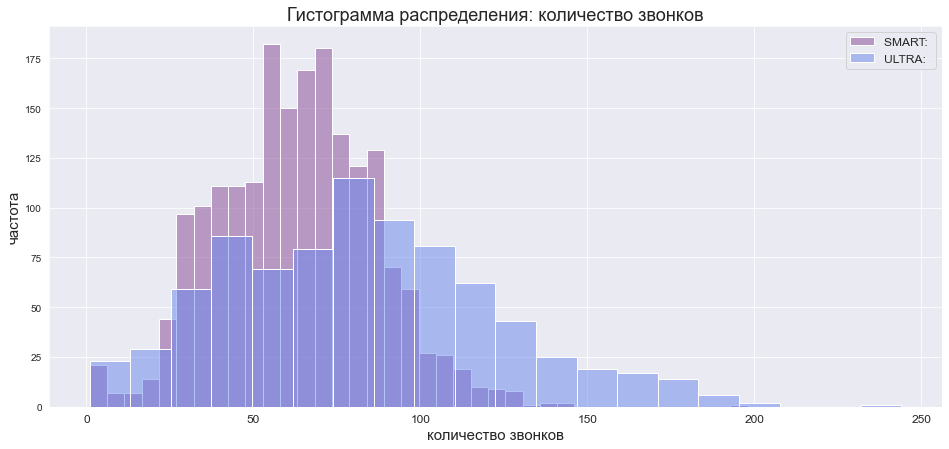

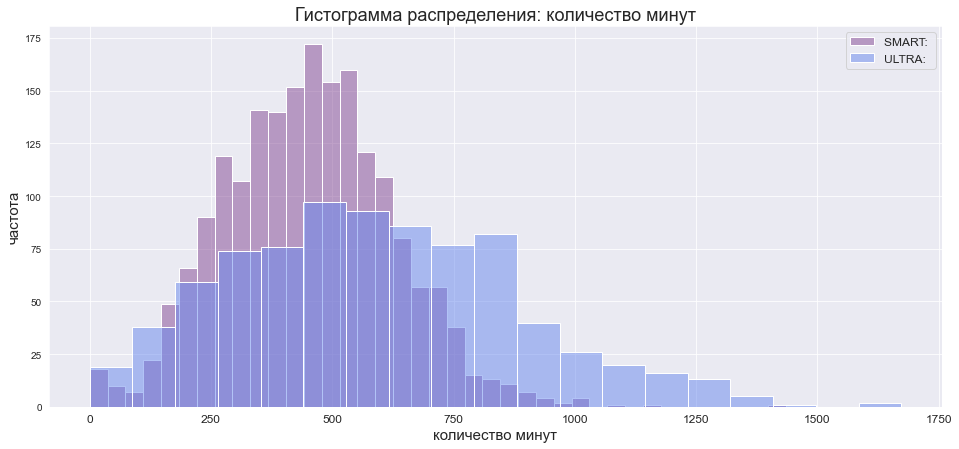

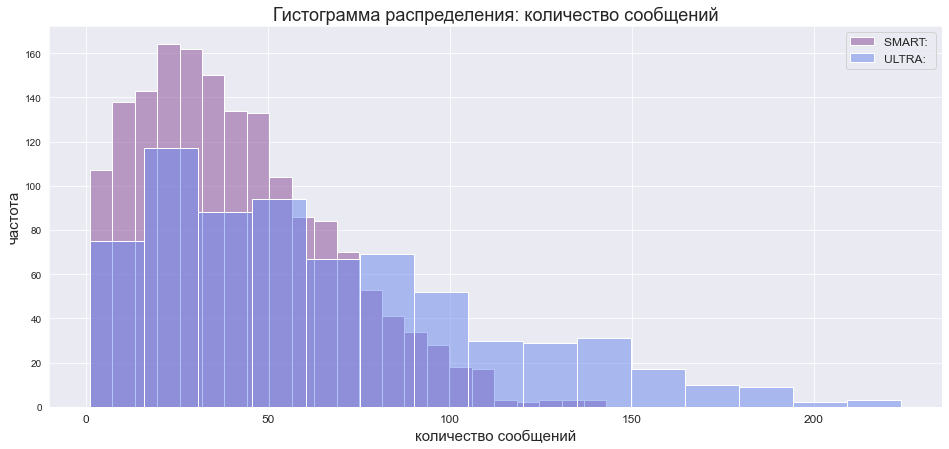

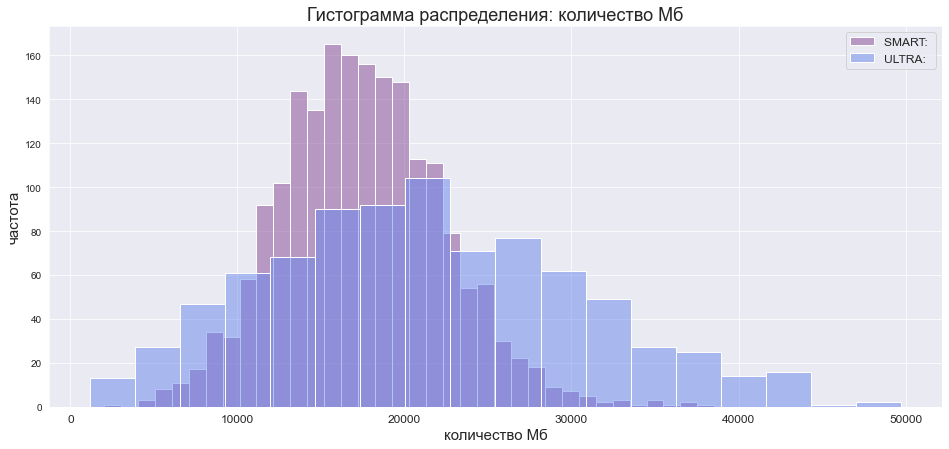

In [96]:
histplots(used_per_month_smart,used_per_month_ultra,['calls','minutes','messages','mb_used'],\
          ['звонков','минут','сообщений','Мб'],'SMART: ','ULTRA: ', 'количество ')

По графикам можно сказать, что у всех показателей обоих тарифов распределение близкое к нормальному, но у смс-сообщениий есть скос вправо у обоих тарифов.
Разброс значений больше у показателей тарифа 'Ультра'.

Теперь построим гистограммы распределения среднемесячной выручки от использования сверх лимита минут, сообщений и интернет-траффика, а также общей выручки с пользователей обоих тарифов.

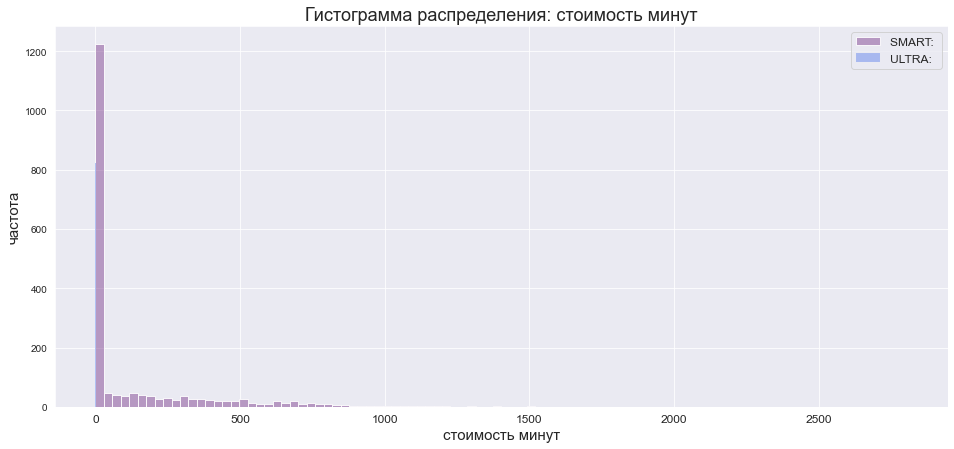

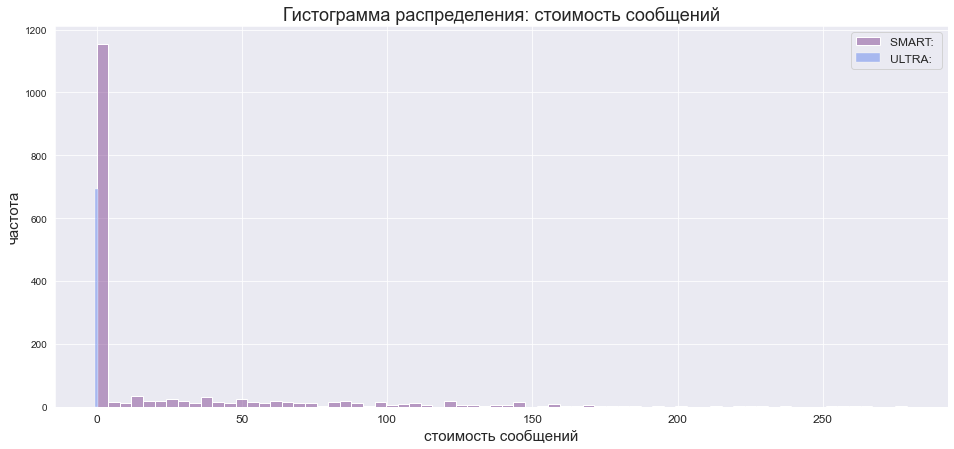

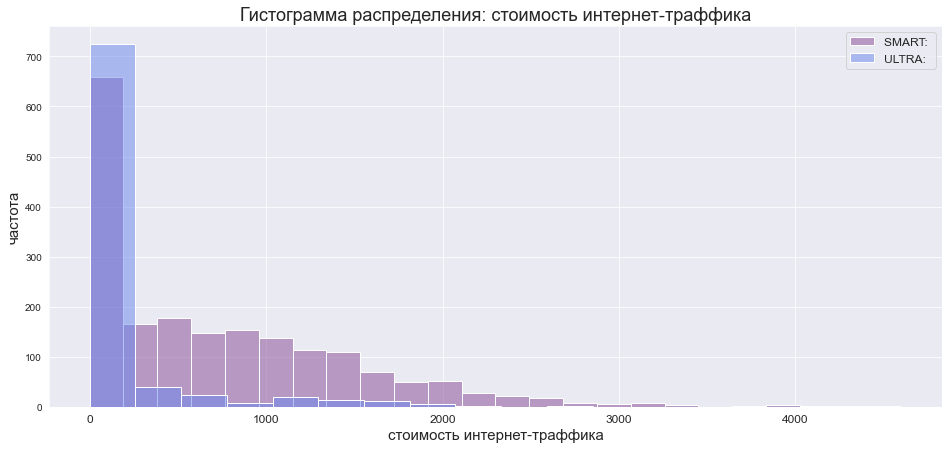

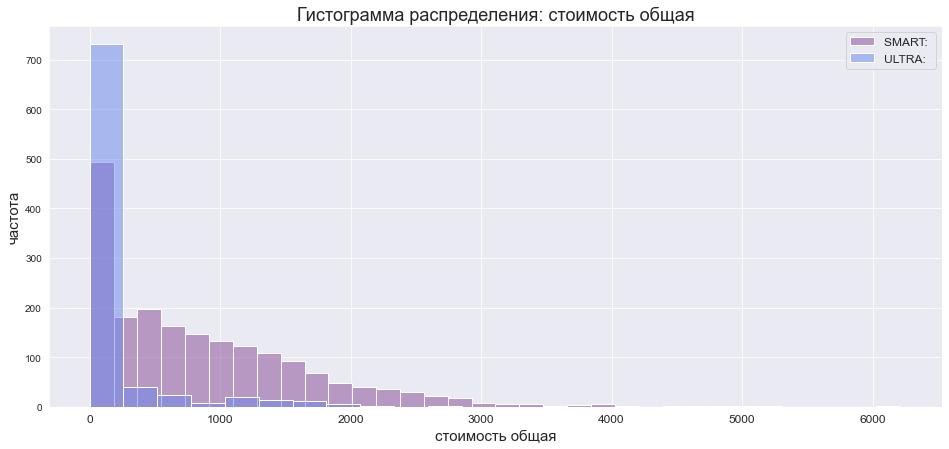

In [95]:
columns = ['minutes_income','messages_income','internet_income','total_income']
titles = ['минут','сообщений','интернет-траффика','общая']
histplots(used_per_month_smart, used_per_month_ultra, columns, titles,'SMART: ', 'ULTRA: ', 'стоимость ')

Из графиков видно, что пользователи тарифа "Смарт" приносят больше выручки. Причем, больше всего выручки приносит интернет.

У тарифа "Ультра" совсем нет прибыли от разговоров и сообщений, и незначительная по сравнению с тарифом "Смарт" выручка от использования интернета.

Напишем функцию analysis, которая рассчитает среднее, дисперсию и стандартное отклонение для двух датафремов для определенного параметра, чтобы сравнить показатели датафреймов.

In [ ]:
# df1 и df2 - сравниваемые датафреймы
# name1,name2 - названия для различия датафреймов
# parameter - название колонки, показатели которой сравниваем
def analysis(df1,df2,name1,name2,parameter):
    print('Среднее значение',parameter,'в месяц:')
    print(name1,' :',round(df1[df1[parameter]<99999][parameter].mean(),2))
    print(name2,' :',round(df2[df2[parameter]<99999][parameter].mean(),2))
    print()
    print('Дисперсия',parameter,'в месяц:')
    print(name1,' :',round(np.var(df1[df1[parameter]<99999][parameter]),2))
    print(name2,' :',round(np.var(df2[df2[parameter]<99999][parameter]),2))
    print()
    print('Стандартное отклонение',parameter,'в месяц:')
    print(name1,' :',round(np.std(df1[df1[parameter]<99999][parameter]),2))
    print(name2,' :',round(np.std(df2[df2[parameter]<99999][parameter]),2))

Сравним описвтельную статистику пользователей двух тарифов.

In [98]:
def analysis1(df,colunms):
    for column in colunms:
        display(df[df[column]!=99999].pivot_table(index= 'tariff', values = column, \
                                                  aggfunc= ['mean', 'var','std', 'median']))

In [99]:
analysis1(used_per_month,['calls','minutes','messages','mb_used','total_income'])

,mean,var,std,median
,calls,calls,calls,calls
tariff,,,,
smart,63.096992,554.190380,23.541248,64.0
ultra,82.507282,1638.359607,40.476655,81.0


,mean,var,std,median
,minutes,minutes,minutes,minutes
tariff,,,,
smart,450.854772,30389.917663,174.327042,451.0
ultra,591.677184,86083.713403,293.400261,569.0


,mean,var,std,median
,messages,messages,messages,messages
tariff,,,,
smart,41.532143,712.850664,26.699263,38.0
ultra,65.662338,2141.920501,46.280887,55.0


,mean,var,std,median
,mb_used,mb_used,mb_used,mb_used
tariff,,,,
smart,17464.557682,2.384095e+07,4882.719359,17251.0
ultra,21246.786052,8.662636e+07,9307.328491,20764.5


,mean,var,std,median
,total_income,total_income,total_income,total_income
tariff,,,,
smart,839.662183,682172.181369,825.937153,600.0
ultra,138.745604,160859.105394,401.072444,0.0


Пользователи тарифа "Ультра" совершают больше звонков и больше по времени говорят по телефону, чем пользователи тарифа "Смарт".

Также пользователи тарифа "Ультра" отправляют больше сообщений и активнее пользуются интернетом.

Теперь сравним общий доход с пользователей обоих тарифов: доход больше приносят пользователи тарифа "Смарт". .

Дисперсии средних значений дохода с пользователей тоже не равны - у "Смарт" она в 4 раза больше дисперсии "Ультра".

#### Вывод 
Пользователи тарифа "Ультра" активнее говорят по телефону, отправляют смс-сообщения и пользуются интернетом, чем пользователи тарифа "Смарт".

Но прибыль больше приносят пользователи тарифа "Смарт". Причем большая часть прибыли - от использования интернета.

### 4.2. Анализ данных пользователей Москвы и регионов

Сравним количество минут разговора, смс-сообщений и интернет-траффика пользователей из Москвы и регионов.

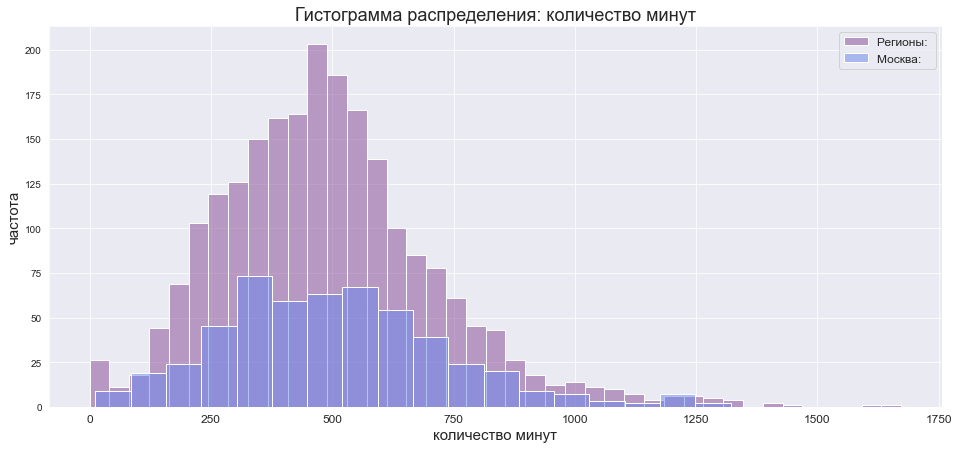

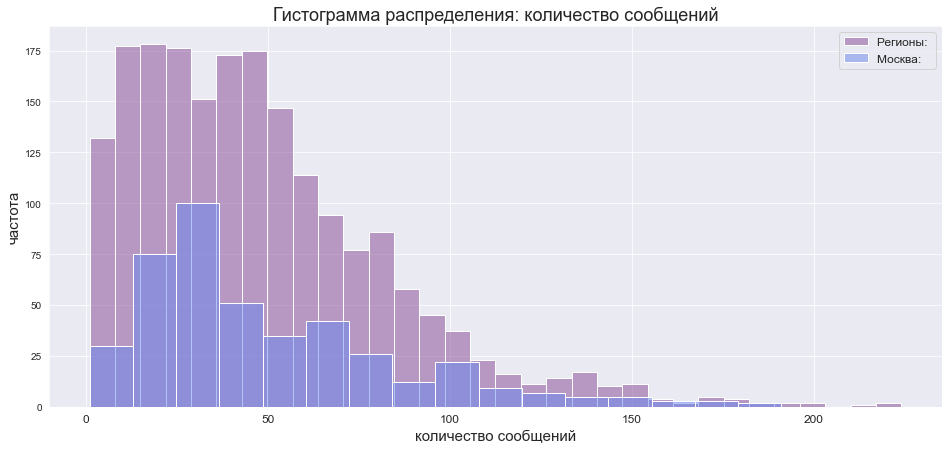

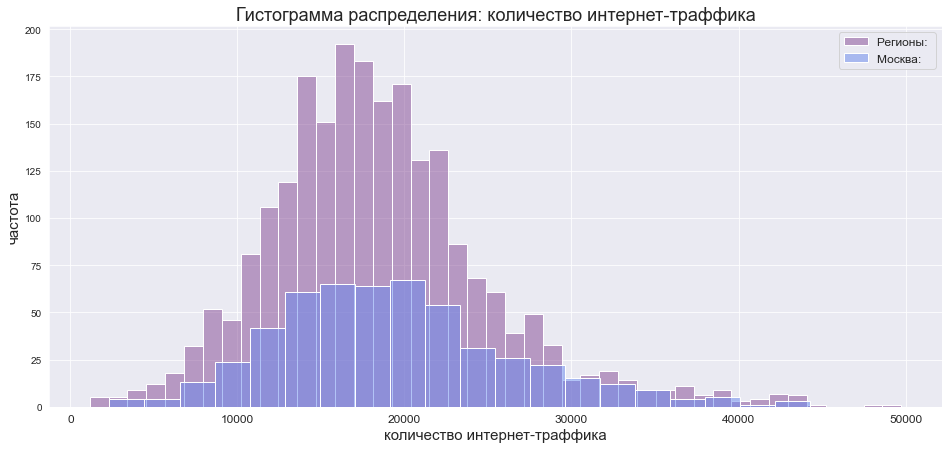

In [94]:
columns = ['minutes','messages','mb_used']
titles = ['минут', 'сообщений', 'интернет-траффика']
histplots(used_per_month_regions,used_per_month_moscow,columns,titles,'Регионы: ', 'Москва: ', 'количество ')

Все количественные показатели выше у регионов.

Сравним выручки с пользователей из Москвы и пользователей из других регионов.

Построим графики распределения средних величин дохода от использованных минут рзговора, отправленных смс-сообщений и использованного интернет-траффика, а также общего дохода пользователей Москвы и регионов.

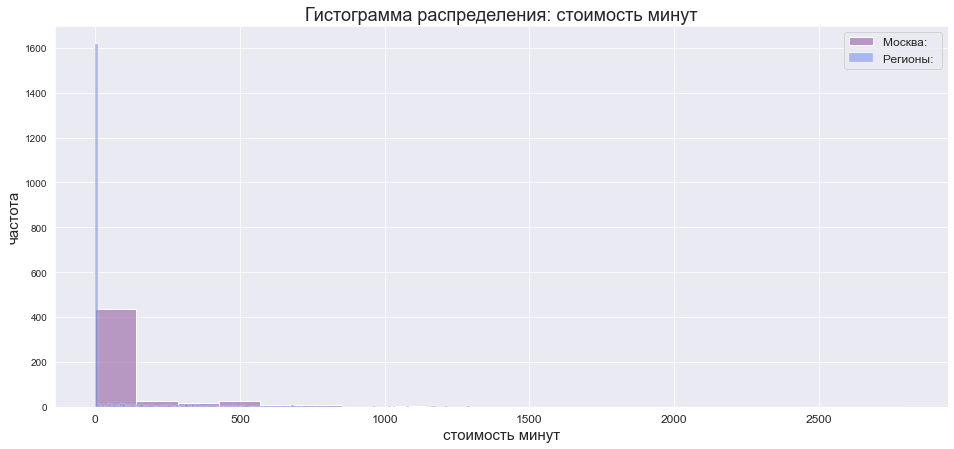

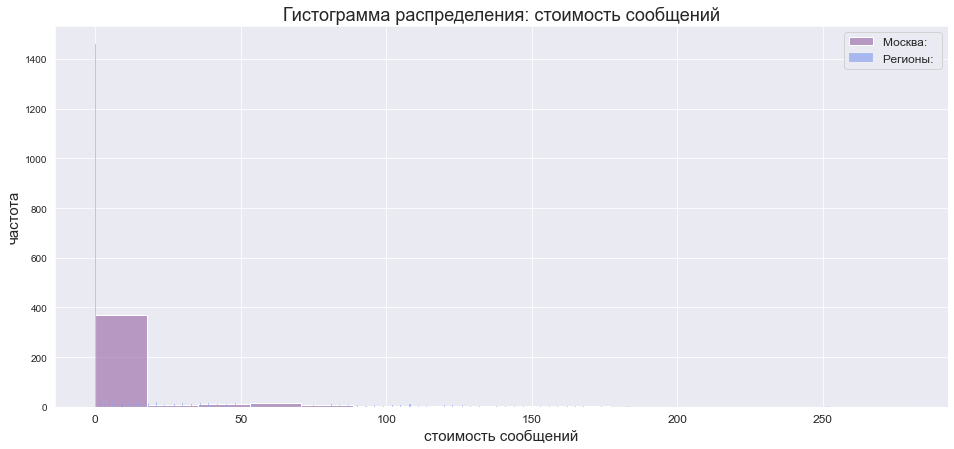

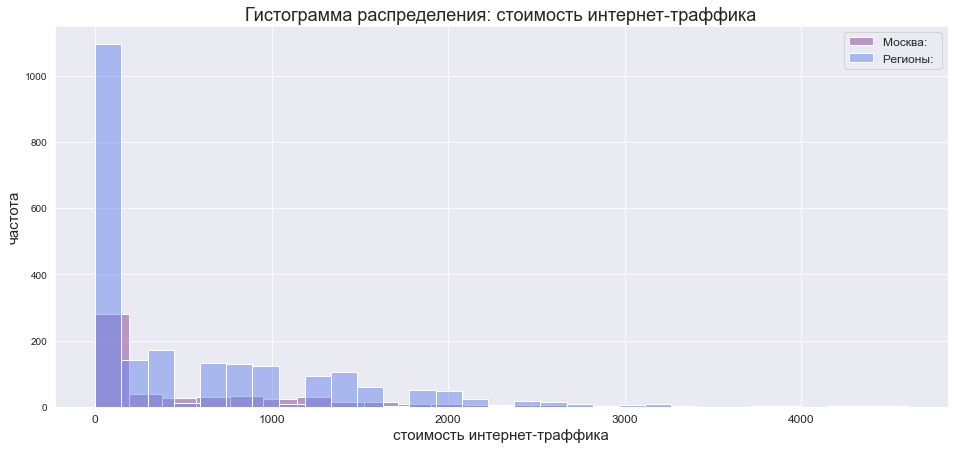

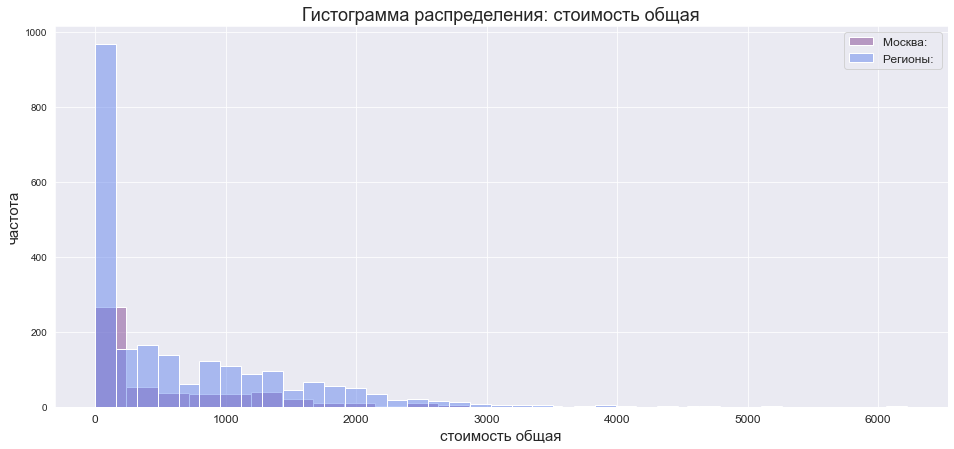

In [62]:
columns = ['minutes_income','messages_income','internet_income','total_income']
titles = ['минут', 'сообщений', 'интернет-траффика', 'общая']
histplots(used_per_month_moscow,used_per_month_regions,columns,titles,'Москва: ','Регионы: ','стоимость ')

По графикам видно, что абоненты Москвы приносят больше дохода от использования минут и сообщений, но доход от использования интернета выше у абонентов из регионов.

По графику общей прибыли можно сделать вывод, что доход выше от абонентов из регионов. 

In [63]:
tarifs_moscow = used_per_month_moscow.pivot_table(index = 'tariff', values = 'user_id', aggfunc = 'nunique', margins = True)\
                                     .reset_index().rename(columns = {'user_id': 'moscow_users'})
tarifs_moscow

,tariff,moscow_users
0,smart,62
1,ultra,32
2,All,94


In [64]:
tarifs_regions = used_per_month_regions.pivot_table(index = 'tariff', values = 'user_id', aggfunc = 'nunique', margins = True)\
                                       .reset_index().rename(columns = {'user_id': 'regions_users'})
tarifs_regions

,tariff,regions_users
0,smart,266
1,ultra,110
2,All,376


In [65]:
tarifs = tarifs_moscow.merge(tarifs_regions, on = 'tariff')
tarifs

,tariff,moscow_users,regions_users
0,smart,62,266
1,ultra,32,110
2,All,94,376


In [79]:
tarifs['moscow_share'] = round(tarifs['moscow_users'] / tarifs.loc[2,'moscow_users'],2)
tarifs['regions_share'] = round(tarifs['regions_users'] / tarifs.loc[2,'regions_users'],2)
tarifs

,tariff,moscow_users,regions_users,moscow_share,regions_share
0,smart,62,266,0.66,0.71
1,ultra,32,110,0.34,0.29
2,All,94,376,1.00,1.00


Тариф "Смарт" популярнее тарифа "Ультра" и в Москве и в регионах, но в Москве доля тарифа "Ультра" чуть выше.

Сравним общий доход московских и региональных пользователей.

In [67]:
analysis(used_per_month_moscow,used_per_month_regions,'Москва','регионы','total_income')

Среднее значение total_income в месяц:
Москва  : 548.34
регионы  : 642.92

Дисперсия total_income в месяц:
Москва  : 509929.92
регионы  : 652091.87

Стандартное отклонение total_income в месяц:
Москва  : 714.09
регионы  : 807.52


#### Вывод
* Пользователи из регионов приносят больше выручки, чем пользователи Москвы.
* Тариф "Смарт" популярнее тарифа "Ультра" и в Москве и в регионах.
* В Москве доля тарифа "Ультра" чуть выше.

## 5. Проверка гипотез

### 5.1. Проверка гипотезы "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются"

Нужно проверить гипотезу "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются".

Так как нулевая гипотеза формулируется исходя из равенства значений, то сформулируем ее так:

<b>Н0: "Средняя выручка с пользователей тарифов «Ультра» равна средней выручке пользователей тарифа «Смарт»".</b>

Альтернативная гипотеза будет такой:

<b>Н1: "Средняя выручка с пользователей тарифа «Ультра» меньше средней выручки с пользователей тарифа "Смарт".</b>

Анализ показал, что средние доходы с пользователей тарифа "Ультра" меньше средних доходов с пользователей "Смарт", поэтому альтернативная гипотеза будет односторонней.

Напишем функции для статистических исследований.

In [85]:
#Функция для проверки, является ли распределение датафрейма df[column] нормальным
def shapiro_test(df,column,text):    
    result = st.shapiro(df[column])
    print(f'p-value для {text}: {result.pvalue:.10f}')
    if result.pvalue < alpha:
        print('Распределение не является нормальным')
    else: print('Распределение близко к нормальному')
        
# Функция для проверки на равенство дисперсий двух выборок df1[column] и df2[column] методом Левене
def levene_test(df1,df2,column):
    result = st.levene(df1[column], df2[column], center='mean', proportiontocut=0.05)
    print(f'p_value = {result.pvalue:.10f}')
    if result.pvalue < alpha:
        print('Дисперсии выборок не равны')
    else: print('Дисперсии выборок равны')
        
# Функция для проверки на равенство дисперсий двух выборок df1[column] и df2[column] методом Бартлетта        
def bartlett_test(df1,df2,column):
    result = st.bartlett(df1[column], df2[column], center='mean', proportiontocut=0.05)
    print(f'p_value = {result.pvalue:.10f}')
    if result.pvalue < alpha:
        print('Дисперсии выборок не равны')
    else: print('Дисперсии выборок равны')    

class color:
   BOLD = '\033[1m'
   END = '\033[0m'

# функция проверки статистических гипотез
# is_hyp2 - признак двусторонней гипотезы (True - гипотеза двусторонняя; False - односторонняя)
def hipothesis(df1,df2,parameter,is_hyp2):
    results = st.ttest_ind(df1[parameter],df2[parameter],equal_var = False)
    alpha = 0.05
    if is_hyp2:
        p_value = results.pvalue
    else:
        p_value = results.pvalue/2
    if p_value < alpha:
        print(color.BOLD + "Недостаточно оснований для принятия нулевой гипотезы. Принимаем альтернативную." + color.END)
    else:
        print(color.BOLD + "Недостаточно оснований для того, чтобы отвергнуть нулевую гипотезу." + color.END) 


На графиках распределение средних доходов абонентов обоих тарифов отличаются от нормального. Проверим выборки на нормальность с помощью теста Шапиро-Уилка. Уровень значимости возьмем 0.05.

In [86]:
alpha = 0.05
shapiro_test(used_per_month_ultra,'total_income','ULTRA')
print()
shapiro_test(used_per_month_smart,'total_income','SMART')

p-value для ULTRA: 0.0000000000
Распределение не является нормальным

p-value для SMART: 0.0000000000
Распределение не является нормальным


Проверим выборки на равенство дисперсий. Т.к. их распределения выборок не являются нормальными, проверять будем с помощью теста Левене. Уровень значимости возьмем 0.05.

In [87]:
levene_test(used_per_month_ultra, used_per_month_smart, 'total_income')

p_value = 0.0000000000
Дисперсии выборок не равны


Проверим размеры датафреймов.

In [88]:
print('Количество пользователей "Ультра":',used_per_month_ultra['user_id'].count())
print('Количество пользователей "Смарт":',used_per_month_smart['user_id'].count())

Количество пользователей "Ультра": 853
Количество пользователей "Смарт": 1933


Дисперсии и размеры исследуемых выборок отличаются.

Поэтому при проверке гипотезы будем использовать значение параметра equal_var = False.

Уровень значимости возьмем 0.05.

In [89]:
hipothesis(used_per_month_ultra,used_per_month_smart,'total_income',False)

Недостаточно оснований для принятия нулевой гипотезы. Принимаем альтернативную.


#### Вывод
В результате исследования была принята альтернативная гипотеза: "Средняя выручка с пользователей тарифа «Ультра» меньше средней выручки с пользователей тарифа "Смарт".

### 5.2. Проверка гипотезы "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов"

Нужно проверить гипотезу "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов".

Так как нулевая гипотеза формулируется исходя из равенства значений, то сформулируем ее так:

<b>Н0: "Cредняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов".</b>

Альтернативная гипотеза будет такой:

<b>Н1: "Cредняя выручка пользователей из Москвы меньше средней выручки пользователей из других регионов".</b>

Альтернативная гипотеза в этом случае односторонняя.

На графике распределения средней выручки абонентов Москвы и регионов не являются нормальными.

Проверим распределения на нормальность с помощиью теста Шапиро-Уилка. Уровень значимости выберем 0.05.

In [90]:
alpha = 0.05
shapiro_test(used_per_month_moscow,'total_income','Москвы')
print()
shapiro_test(used_per_month_regions,'total_income','регионов')

p-value для Москвы: 0.0000000000
Распределение не является нормальным

p-value для регионов: 0.0000000000
Распределение не является нормальным


Теперь проверим выборки на равенство дисперсий. Т.к. распределение в выборках не является нормальным, проверку будем делать с помощью теста Левене. Уровень значимости возьмем 0.05.

In [91]:
levene_test(used_per_month_moscow, used_per_month_regions, 'total_income')

p_value = 0.0018957283
Дисперсии выборок не равны


Проверим размеры датафреймов.

In [92]:
print('Количество пользователей Москвы:',used_per_month_moscow['user_id'].count())
print('Количество пользователей из регионов:',used_per_month_regions['user_id'].count())

Количество пользователей Москвы: 526
Количество пользователей из регионов: 2260


Дисперсии и размеры исследуемых выборок отличаются.

Поэтому при проверке гипотезы тоже будем использовать значение параметра equal_var = False.

Уровень значимости возьмем 0.05.

In [93]:
hipothesis(used_per_month_moscow,used_per_month_regions,'total_income',True)

Недостаточно оснований для принятия нулевой гипотезы. Принимаем альтернативную.


#### Вывод
В результате исследования была принята альтернативная гипотеза: "Cредняя выручка пользователей из Москвы меньше средней выручки пользователей из других регионов".

## 6. Общий вывод:

На основании проведенного анализа данных можно сделать следующие <b>выводы:</b>
* Пользователи тарифа "Ультра" пользуются услугами оператора активнее пользователей тарифа "Смарт".
* Прибыль больше приносят пользователи тарифа "Смарт". Причем большая часть прибыли - от использования интернета.
* Выручка абонентов из регионов больше выручки московских абонентов.

<b>Рекомендации:</b>
* Тариф "Смарт" можно оставить для пользователей из регионов.
* Для пользователей Москвы можно создать новый тариф, который по стоимости и пакету услуг будет промежуточным между  "Ультра" и "Смарт" .